### **Linear Regression**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=883fc49735c99ed39dacb4c93dbcdc8e400743c24a58790cf2c67bbec8621fe2
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import pyspark
print(pyspark.__version__)

3.5.1


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *


spark = SparkSession.builder \
    .appName("project") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.memory.fraction", "0.6") \
    .config("spark.memory.storageFraction", "0.5") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC") \
    .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC") \
    .master("local[4]") \
    .getOrCreate()

In [ ]:
from pyspark.sql.functions import col, when, count, mean
from pyspark.sql.types import *
import pandas as pd

In [ ]:
df_all = spark.read.csv('/content/drive/MyDrive/itc686_project/*', header=True)


In [ ]:
df_selective = df_all['Year', 'Month', 'DayofMonth', 'DayOfWeek',
            'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
            'Marketing_Airline_Network', 'Flight_Number_Marketing_Airline',
            'Tail_Number', 'ActualElapsedTime', 'CRSElapsedTime',
            'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
            'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled',
            'CancellationCode','CarrierDelay',
            'WeatherDelay', 'NASDelay', 'SecurityDelay',
            'LateAircraftDelay','Operating_Airline ','DepDelayMinutes']

In [ ]:

schema_types = {
    "Year": IntegerType(),
    "Month": IntegerType(),
    "DayofMonth": IntegerType(),
    "DayOfWeek": IntegerType(),
    "DepTime": IntegerType(),
    "CRSDepTime": IntegerType(),
    "ArrTime": IntegerType(),
    "CRSArrTime": IntegerType(),
    "Marketing_Airline_Network": StringType(),
    "Flight_Number_Marketing_Airline": IntegerType(),
    "Tail_Number": StringType(),
    "ActualElapsedTime": IntegerType(),
    "CRSElapsedTime": IntegerType(),
    "AirTime": IntegerType(),
    "ArrDelay": IntegerType(),
    "DepDelay": IntegerType(),
    "Origin": StringType(),
    "Dest": StringType(),
    "Distance": IntegerType(),
    "TaxiIn": IntegerType(),
    "TaxiOut": IntegerType(),
    "Cancelled": IntegerType(),
    "CancellationCode": StringType(),
    "CarrierDelay": IntegerType(),
    "WeatherDelay": IntegerType(),
    "NASDelay": IntegerType(),
    "SecurityDelay": IntegerType(),
    "LateAircraftDelay": IntegerType(),
    'Operating_Airline ': StringType(),
    'DepDelayMinutes':IntegerType()
}

for column, dtype in schema_types.items():
    if isinstance(dtype, IntegerType):
        df_selective = df_selective.withColumn(column, col(column).cast("int"))


In [ ]:
df_selective=df_selective.dropna(how='any',subset=['Tail_Number','Origin','Dest',"DepDelay", "ArrDelay",'AirTime'])
df_delay= df_selective.filter(col('ArrDelay')>=15)
df_cancelled=df_selective.filter((col('Cancelled') == 1) & ~col('CancellationCode').isNull())

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [ ]:
from pyspark.sql.functions import col, isnan, when, count

# Checking for null or NaN values in ActualElapsedTime
df_selective.select([count(when(isnan(col(c)) | col(c).isNull(), c)).alias(c) for c in ["ActualElapsedTime"]]).show()


# Option 1: Removing rows where ActualElapsedTime is null or NaN
df_clean = df_selective.filter(df_selective.ActualElapsedTime.isNotNull())

# Option 2: Filling NaN or null values with the mean or a specific value (e.g., the mean of ActualElapsedTime)
mean_value = df_selective.agg({"ActualElapsedTime": "mean"}).first()[0]
df_filled = df_selective.na.fill({'ActualElapsedTime': mean_value})

# Proceed with your existing code, using df_clean or df_filled instead of df_selective
feature_cols = ['CRSElapsedTime', 'Distance']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
lr = LinearRegression(featuresCol='features', labelCol='ActualElapsedTime')
pipeline = Pipeline(stages=[assembler, lr])


# Split the data into training and testing sets
train_data, test_data = df_filled.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions_m = model.transform(test_data)

# Show some prediction results
predictions_m.select("features", "ActualElapsedTime", "prediction").show(5)

# Print the coefficients and intercept
print("Coefficients: " + str(model.stages[-1].coefficients))
print("Intercept: " + str(model.stages[-1].intercept))

+-----------------+
|ActualElapsedTime|
+-----------------+
|                0|
+-----------------+

+--------------+-----------------+------------------+
|      features|ActualElapsedTime|        prediction|
+--------------+-----------------+------------------+
|[269.0,2125.0]|              279| 266.0497473392992|
|[229.0,1747.0]|              242|225.84450644331022|
|[283.0,2342.0]|              283| 281.7586122901381|
|[277.0,2174.0]|              272| 273.5766867233299|
|[156.0,1055.0]|              151|152.42838790175404|
+--------------+-----------------+------------------+
only showing top 5 rows

Coefficients: [0.822487108327183,0.019327398314554673]
Intercept: 3.7299937808583095


In [ ]:
predictions=predictions_m.select("prediction", "ActualElapsedTime").toPandas()


In [ ]:
# Create regression evaluators
evaluator_rmse = RegressionEvaluator(labelCol="ActualElapsedTime", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="ActualElapsedTime", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="ActualElapsedTime", predictionCol="prediction", metricName="r2")

# Calculate RMSE, MAE, and R^2
rmse = evaluator_rmse.evaluate(predictions_m)
mae = evaluator_mae.evaluate(predictions_m)
r2 = evaluator_r2.evaluate(predictions_m)

# Print the results
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2: {r2}")


Root Mean Squared Error (RMSE): 13.207738026791581
Mean Absolute Error (MAE): 9.235726787079724
R^2: 0.9651810491649774


In [ ]:
pip install matplotlib seaborn


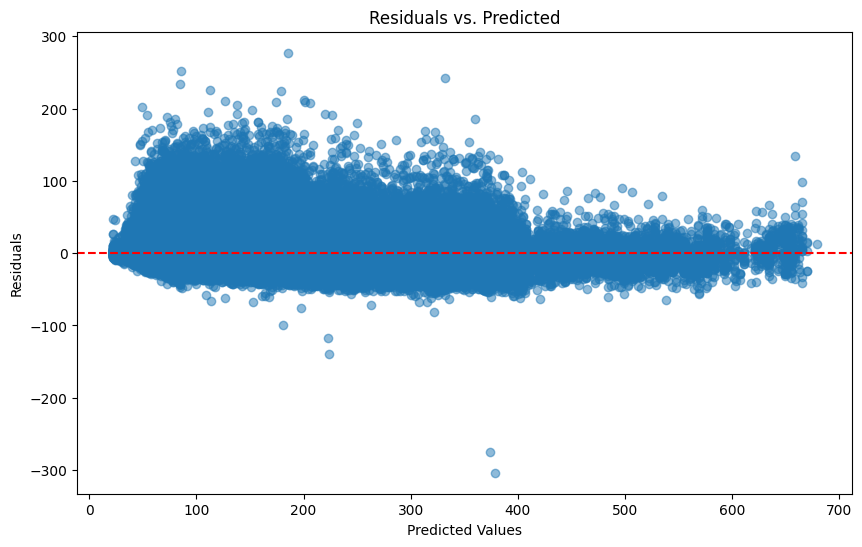

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



# Calculate residuals
predictions['Residuals'] = predictions['ActualElapsedTime'] - predictions['prediction']

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(predictions['prediction'], predictions['Residuals'], alpha=0.5)
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


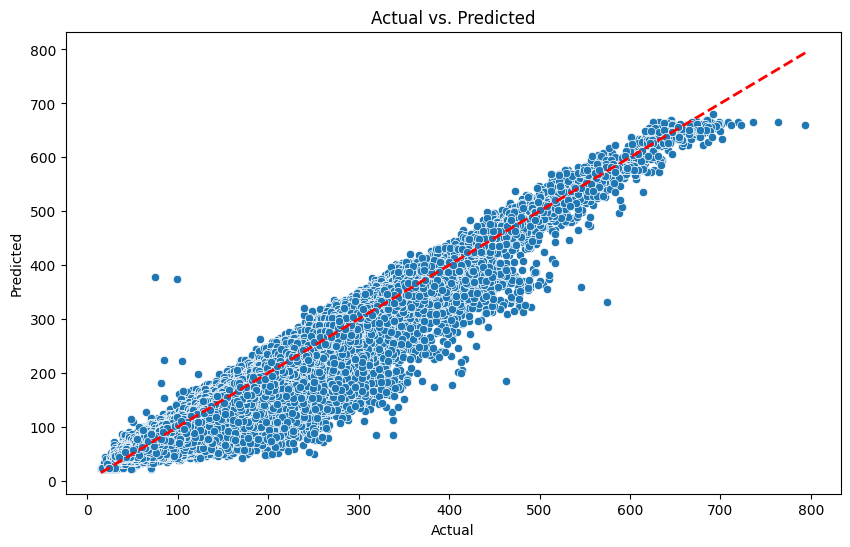

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions['ActualElapsedTime'], y=predictions['prediction'])
plt.plot([predictions['ActualElapsedTime'].min(), predictions['ActualElapsedTime'].max()],
         [predictions['ActualElapsedTime'].min(), predictions['ActualElapsedTime'].max()],
         color='red', lw=2, linestyle='--')
plt.title('Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


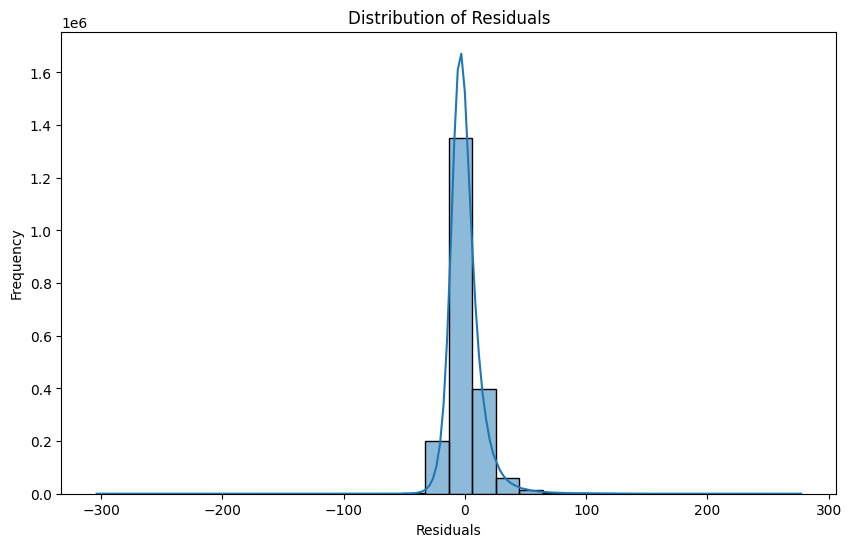

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(predictions['Residuals'], bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
